In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from cmath import isinf
import torch.nn.functional as F
import seaborn as sns
from torch.utils.data import Dataset, DataLoader, Subset, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import pandas as pd
import math
from utils_v import compute_target_score, estimate_target, save_model
from cmath import isinf
import torch.nn.functional as F
from sklearn.model_selection import train_test_split, KFold, LearningCurveDisplay, learning_curve
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error, r2_score
from helper_classes import MatData, KernelizedSupCon, MLP, cauchy, rbf, gaussian_kernel

In [2]:
!pwd

/gpfs3/well/margulies/users/cpy397/contrastive-learning


In [3]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
def gaussian_kernel(x, krnl_sigma = 0.5):
    x1 = x[:, :1] - x[:, :1].T
    x2 = x[:, 1:2] - x[:, 1:2].T
    x = x1**2 + x2**2
    return torch.exp(-x / (2*(krnl_sigma**2))) / (math.sqrt(krnl_sigma*torch.pi)*1)

In [5]:
class CustomContrastiveLoss(nn.Module): # my custom loss for my mental health
    def __init__(self, margin=1.0):
        super(CustomContrastiveLoss, self).__init__()
        self.margin = margin  # how far apart the dissimilar pairs should be pushed

    def forward(self, features, targets):
        positive_dist = torch.norm(features - targets, p=2, dim=1)

        # Euclidean distances for negative pairs and apply margin
        # For each target, calculate its distance to all other features and targets
        batch_size = features.shape[0]
        repulsion_loss = 0.0
        for i in range(batch_size):
            for j in range(batch_size):
                if i != j:
                    # Distance from target i to features j
                    dist_to_features = torch.norm(targets[i] - features[j], p=2)
                    # Distance from target i to targets j
                    dist_to_targets = torch.norm(targets[i] - targets[j], p=2)
                    # Apply margin and accumulate repulsion loss
                    repulsion_loss += F.relu(self.margin - dist_to_features) + F.relu(self.margin - dist_to_targets)

        # Mean over all pairs for both attraction and repulsion components
        attraction_loss = positive_dist.mean()
        repulsion_loss /= (batch_size * (batch_size - 1) * 2)  # Normalize by number of negative pairs

        # Total loss: minimize attraction while maximizing repulsion
        total_loss = attraction_loss + repulsion_loss

        return total_loss

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomContrastiveLoss(nn.Module):
    def __init__(self, sigma=1):
        super(CustomContrastiveLoss, self).__init__()
#         self.margin = margin 
        self.sigma = sigma 
    
    def gaussian_kernel(self, x, y):
        # squared Euclidean distance
        squared_dist = torch.sum((x - y) ** 2, dim=1)
        # Apply the Gaussian kernel
        return torch.exp(-squared_dist / (2 * self.sigma ** 2))

    def forward(self, features, targets):
        # Gaussian kernel for the positive pairs
        positive_kernel = self.gaussian_kernel(features, targets)

        batch_size = features.shape[0]
        repulsion_loss = 0.0
        for i in range(batch_size):
            for j in range(batch_size):
                if i != j:
                    #Gaussian kernel for distances to features and targets
                    kernel_to_features = self.gaussian_kernel(targets[i].unsqueeze(0), features[j].unsqueeze(0))
                    kernel_to_targets = self.gaussian_kernel(targets[i].unsqueeze(0), targets[j].unsqueeze(0))
                    
                    repulsion_loss += kernel_to_features + kernel_to_targets

        attraction_loss = 1-positive_kernel.mean()
        repulsion_loss = repulsion_loss / (batch_size * (batch_size - 1))  # Normalize by the number of negative pairs
        # Total loss
        total_loss = attraction_loss + repulsion_loss

        return total_loss


In [7]:
def standardize_dataset(dataset):
    features = torch.vstack([dataset[i][0] for i in range(len(dataset))])
    targets = torch.vstack([dataset[i][1] for i in range(len(dataset))])
    print(features.shape)
    print(targets.shape)
    
    features_mean = features.mean(dim=0)
    features_std = features.std(dim=0)
    targets_mean = targets.mean(dim=0)
    targets_std = targets.std(dim=0)
    
    features_std[features_std == 0] = 1
    targets_std[targets_std == 0] = 1
    
    standardized_features = (features - features_mean) / features_std
    standardized_targets = (targets - targets_mean) / targets_std
    
    standardized_dataset = TensorDataset(standardized_features, standardized_targets)
    
    return standardized_dataset

In [8]:
dataset = MatData("vectorized_matrices_la5c.npy", "hopkins_age.npy")

In [9]:
train_indices, test_indices = train_test_split(np.arange(len(dataset)), train_size = 15, test_size = 5, random_state=42) #train_size = 5
train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

In [10]:
# input_dim_feat = 499500 # vectorized mat, diagonal discarded
# input_dim_target = 59
# # the rest is arbitrary
# hidden_dim_feat_1 = 1024
# hidden_dim_feat_2 = 512
# hidden_dim_target_1 = 24
# hidden_dim_target_2 = 8
# output_dim = 2
# num_epochs = 1000

input_dim_feat = 499500 # vectorized mat, diagonal discarded
input_dim_target = 59
# the rest is arbitrary
hidden_dim_feat = 1000
hidden_dim_target = 24
output_dim = 2
num_epochs = 1000


In [11]:
temperature = 0.5
base_temperature = 0.5 # too low values return nan loss
lr = 0.01 # too low values return nan loss
kernel = gaussian_kernel
batch_size = 3 # too low values return nan loss

In [12]:
standardized_train_dataset = standardize_dataset(train_dataset)
std_train_loader = DataLoader(standardized_train_dataset, batch_size=batch_size, shuffle=True)

standardized_test_dataset = standardize_dataset(test_dataset)
std_test_loader = DataLoader(standardized_test_dataset, batch_size=batch_size, shuffle=True)

torch.Size([15, 499500])
torch.Size([15, 59])
torch.Size([5, 499500])
torch.Size([5, 59])


In [13]:

model = MLP(input_dim_feat, input_dim_target, hidden_dim_feat, hidden_dim_target, output_dim).to(device)
# criterion = KernelizedSupCon(method='expw', temperature=temperature, base_temperature=base_temperature, kernel=kernel, delta_reduction = 'mean')
criterion = CustomContrastiveLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)


for epoch in range(num_epochs):
    model.train()
    batch_losses = []
    for batch_num, (features, targets) in enumerate(std_train_loader):
        features, targets = features.to(device), targets.to(device)
        optimizer.zero_grad()
        out_feat, out_target = model(features, targets)
        loss = criterion(out_feat, out_target)
        loss.backward()
        batch_losses.append(loss.item())
        optimizer.step()
    print(f'Epoch {epoch} | Mean Loss {sum(batch_losses)/len(batch_losses)}')


mape_train, _ = compute_target_score(model, std_train_loader, std_test_loader, device, 'mape')
r2_train, _ = compute_target_score(model, std_train_loader, std_test_loader, device, 'r2')
# results_cv.append(['Overall', mape_train, r2_train, mape_val, r2_val])
print(mape_train, r2_train)


Epoch 0 | Mean Loss 1.4282645463943482
Epoch 1 | Mean Loss 1.2388499975204468
Epoch 2 | Mean Loss 1.330004906654358
Epoch 3 | Mean Loss 1.3630671739578246
Epoch 4 | Mean Loss 1.3614596605300904
Epoch 5 | Mean Loss 1.2679975271224975
Epoch 6 | Mean Loss 1.2286694049835205
Epoch 7 | Mean Loss 1.137897253036499
Epoch 8 | Mean Loss 1.2791667461395264
Epoch 9 | Mean Loss 1.308250331878662
Epoch 10 | Mean Loss 1.3449418783187865
Epoch 11 | Mean Loss 1.180994200706482
Epoch 12 | Mean Loss 1.333124577999115
Epoch 13 | Mean Loss 1.3093904495239257
Epoch 14 | Mean Loss 1.145721423625946
Epoch 15 | Mean Loss 1.0048222661018371
Epoch 16 | Mean Loss 1.1212452411651612
Epoch 17 | Mean Loss 1.0722813487052918
Epoch 18 | Mean Loss 1.1274858593940735
Epoch 19 | Mean Loss 1.092402458190918
Epoch 20 | Mean Loss 1.0981200575828551
Epoch 21 | Mean Loss 0.8517375707626342
Epoch 22 | Mean Loss 0.9348590254783631
Epoch 23 | Mean Loss 1.0709790110588073
Epoch 24 | Mean Loss 0.7519513726234436
Epoch 25 | Mean L

Epoch 204 | Mean Loss 0.6979506075382232
Epoch 205 | Mean Loss 0.6407691836357117
Epoch 206 | Mean Loss 0.556760573387146
Epoch 207 | Mean Loss 0.6031006634235382
Epoch 208 | Mean Loss 0.6740041255950928
Epoch 209 | Mean Loss 0.5678052425384521
Epoch 210 | Mean Loss 0.7900063216686248
Epoch 211 | Mean Loss 0.5855480074882508
Epoch 212 | Mean Loss 0.6832245469093323
Epoch 213 | Mean Loss 0.6863324105739593
Epoch 214 | Mean Loss 0.6665589928627014
Epoch 215 | Mean Loss 0.5672900140285492
Epoch 216 | Mean Loss 0.6330519378185272
Epoch 217 | Mean Loss 0.5394768059253693
Epoch 218 | Mean Loss 0.516049987077713
Epoch 219 | Mean Loss 0.6540063858032227
Epoch 220 | Mean Loss 0.6388765811920166
Epoch 221 | Mean Loss 0.5732151210308075
Epoch 222 | Mean Loss 0.6308113515377045
Epoch 223 | Mean Loss 0.5561292111873627
Epoch 224 | Mean Loss 0.602631664276123
Epoch 225 | Mean Loss 0.5595834434032441
Epoch 226 | Mean Loss 0.5499762415885925
Epoch 227 | Mean Loss 0.780508291721344
Epoch 228 | Mean Los

Epoch 405 | Mean Loss 0.5681094110012055
Epoch 406 | Mean Loss 0.6274502396583557
Epoch 407 | Mean Loss 0.5766634583473206
Epoch 408 | Mean Loss 0.7240039229393005
Epoch 409 | Mean Loss 0.6140726923942565
Epoch 410 | Mean Loss 0.6264643192291259
Epoch 411 | Mean Loss 0.5072054386138916
Epoch 412 | Mean Loss 0.569237232208252
Epoch 413 | Mean Loss 0.5477044105529785
Epoch 414 | Mean Loss 0.5464370489120484
Epoch 415 | Mean Loss 0.5411989688873291
Epoch 416 | Mean Loss 0.6190925717353821
Epoch 417 | Mean Loss 0.5889998853206635
Epoch 418 | Mean Loss 0.5880217611789703
Epoch 419 | Mean Loss 0.5861999869346619
Epoch 420 | Mean Loss 0.6165292978286743
Epoch 421 | Mean Loss 0.6036134481430053
Epoch 422 | Mean Loss 0.6193640768527985
Epoch 423 | Mean Loss 0.5938497126102448
Epoch 424 | Mean Loss 0.6139379978179932
Epoch 425 | Mean Loss 0.5401076018810272
Epoch 426 | Mean Loss 0.6299473166465759
Epoch 427 | Mean Loss 0.6586987257003785
Epoch 428 | Mean Loss 0.5122273027896881
Epoch 429 | Mean 

Epoch 606 | Mean Loss 0.7046568393707275
Epoch 607 | Mean Loss 0.6173653960227966
Epoch 608 | Mean Loss 0.6054921090602875
Epoch 609 | Mean Loss 0.5318281829357148
Epoch 610 | Mean Loss 0.6433946073055268
Epoch 611 | Mean Loss 0.6829864203929901
Epoch 612 | Mean Loss 0.6211665332317352
Epoch 613 | Mean Loss 0.5913054406642914
Epoch 614 | Mean Loss 0.5559237957000732
Epoch 615 | Mean Loss 0.5110433101654053
Epoch 616 | Mean Loss 0.629755973815918
Epoch 617 | Mean Loss 0.531123548746109
Epoch 618 | Mean Loss 0.5237591028213501
Epoch 619 | Mean Loss 0.6367676854133606
Epoch 620 | Mean Loss 0.5119327306747437
Epoch 621 | Mean Loss 0.6568287968635559
Epoch 622 | Mean Loss 0.6445662677288055
Epoch 623 | Mean Loss 0.5333601891994476
Epoch 624 | Mean Loss 0.6719141602516174
Epoch 625 | Mean Loss 0.56060950756073
Epoch 626 | Mean Loss 0.5712808847427369
Epoch 627 | Mean Loss 0.6834572315216064
Epoch 628 | Mean Loss 0.5474390387535095
Epoch 629 | Mean Loss 0.6287112414836884
Epoch 630 | Mean Los

Epoch 807 | Mean Loss 0.6361471176147461
Epoch 808 | Mean Loss 0.5514614462852478
Epoch 809 | Mean Loss 0.6638439416885376
Epoch 810 | Mean Loss 0.6212151348590851
Epoch 811 | Mean Loss 0.5674781322479248
Epoch 812 | Mean Loss 0.6592945575714111
Epoch 813 | Mean Loss 0.5302160024642945
Epoch 814 | Mean Loss 0.7054629385471344
Epoch 815 | Mean Loss 0.5519458532333374
Epoch 816 | Mean Loss 0.7086557865142822
Epoch 817 | Mean Loss 0.5672955930233001
Epoch 818 | Mean Loss 0.5415077924728393
Epoch 819 | Mean Loss 0.6015425801277161
Epoch 820 | Mean Loss 0.6265779495239258
Epoch 821 | Mean Loss 0.5174521088600159
Epoch 822 | Mean Loss 0.6232927143573761
Epoch 823 | Mean Loss 0.5942933797836304
Epoch 824 | Mean Loss 0.49752240180969237
Epoch 825 | Mean Loss 0.6072225153446198
Epoch 826 | Mean Loss 0.5978480398654937
Epoch 827 | Mean Loss 0.5572715044021607
Epoch 828 | Mean Loss 0.4926649808883667
Epoch 829 | Mean Loss 0.6243685901165008
Epoch 830 | Mean Loss 0.5091009080410004
Epoch 831 | Mea

TypeError: forward() missing 1 required positional argument: 'y'

In [ ]:
# results_df = pd.DataFrame(results_cv, columns=['Fold', 'Train_MAPE', 'Train_R2', 'Val_MAPE', 'Val_R2'])
# results_df.to_csv('cv_results_hopkins.csv', index=False)

## Testing

In [ ]:
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
# features = torch.vstack([test_dataset[i][0] for i in range(len(test_loader))])
# targets = torch.vstack([test_dataset[i][1] for i in range(len(test_loader))])
# features_mean, features_std, targets_mean, targets_std = compute_global_stats(test_dataset)
# standardized_features = (features - features_mean) / features_std
# standardized_targets = (targets - targets_mean) / targets_std
# standardized_test_dataset = TensorDataset(standardized_features, standardized_targets)
# test_loader = DataLoader(standardized_test_dataset, batch_size=batch_size, shuffle=True)

In [27]:
model.eval()
test_losses = []
emb_features = [] # saving the embedded features for each batch
emb_targets = []
with torch.no_grad():
    total_loss = 0
    total_samples = 0
    for batch_num, (features, targets) in enumerate(std_test_loader):
        features = features.to(device).float()
        targets = targets.to(device)

        out_feat, out_target = model(features, targets)
        emb_features.append(out_feat.cpu())
        emb_targets.append(out_target.cpu())
        loss = criterion(out_feat, out_target)
        test_losses.append(loss.item())
        total_loss += loss.item() * features.size(0)
        total_samples += features.size(0)
        
    test_losses =np.array(test_losses)
    average_loss = total_loss / total_samples
    print('Mean Test Loss: %6.2f' % (average_loss))
    #np.save(f"losses/test_losses_batch{batch_num}.npy", test_losses)

Mean Test Loss:   1.28


In [28]:
emb_features = torch.row_stack(emb_features)

In [29]:
emb_targets = torch.row_stack(emb_targets)

In [30]:
emb_features = pd.DataFrame(emb_features,columns = ["Dim_1", "Dim_2"])

In [31]:
emb_targets = pd.DataFrame(emb_targets,columns = ["Dim_1", "Dim_2"])

In [32]:
emb_features["sub"] = np.arange(1, len(emb_features) +1)
emb_targets["sub"] = np.arange(1, len(emb_targets) +1)
emb_features["Type"] = 'Features'
emb_targets["Type"] = 'Targets'


/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and w

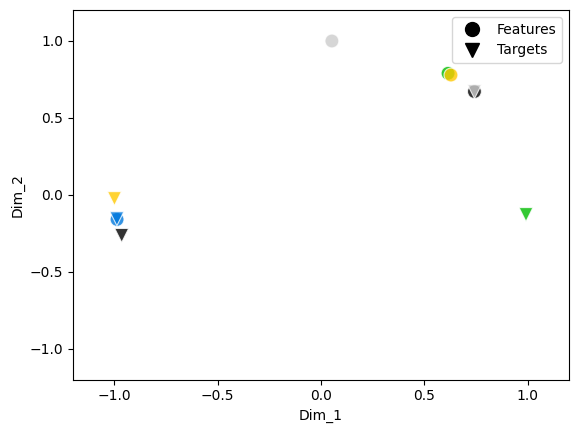

In [33]:
# time to cry
# I probably messed up the original loss. Went over it multiple times
import matplotlib.lines as mlines

sns.scatterplot(emb_features, x = 'Dim_1', y = 'Dim_2', s = 100, alpha = 0.8, hue = 'sub', palette = 'nipy_spectral', label='Features')
sns.scatterplot(emb_targets, x = 'Dim_1', marker = 'v', y = 'Dim_2', s = 100, alpha = 0.8, hue = 'sub', palette = 'nipy_spectral', label='Targets')
plt.xlim(-1.2, 1.2)
plt.ylim(-1.2, 1.2)

feature_handle = mlines.Line2D([], [], color='black', marker='o', linestyle='None', markersize=10, label='Features')
target_handle = mlines.Line2D([], [], color='black', marker='v', linestyle='None', markersize=10, label='Targets')

plt.legend(handles=[feature_handle, target_handle])

## Learning curve

In [50]:
from estimators import TargetEstimator
from utils_v import gather_feats_targets

X_train, y_train = gather_feats_targets(model, std_train_loader, device)
X_test, y_test = gather_feats_targets(model, std_test_loader, device)


TypeError: forward() missing 1 required positional argument: 'y'

In [30]:
X = np.row_stack((X_train, X_test))
y = np.concatenate((y_train, y_test))

In [31]:
estimator = TargetEstimator()

In [32]:
train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, scoring = 'r2') #neg_mean_absolute_percentage_error


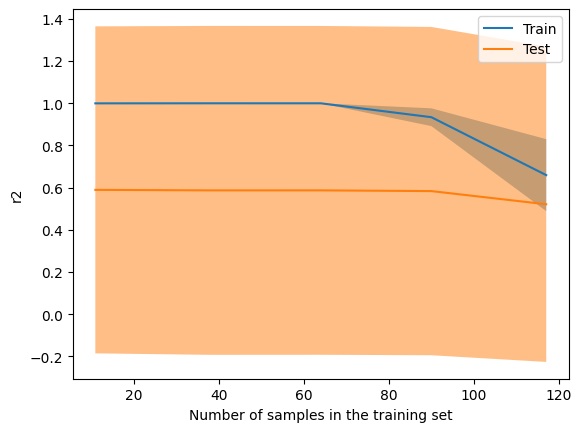

In [33]:
display = LearningCurveDisplay(train_sizes=train_sizes, train_scores=train_scores, test_scores=test_scores, score_name="r2")
display.plot()
plt.show()
